In [ ]:
pip install pyspark

     |████████████████████████████████| 212.3MB 76kB/s 
     |████████████████████████████████| 204kB 54.4MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=29d1f6b44c5d15f713a8273ef0b0ad4e7772efaada58b810d95f50c862b6a951
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
# importing necessary libraries
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
     \ 150.6MB 1.6MB/s
     |████████████████████████████████| 6.5MB 11.6MB/s 
     |████████████████████████████████| 225kB 56.8MB/s 
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759566 sha256=5ca1149473b27c15d02ca6cc27d69f7bc8c28747d4fec39200af8cba6dd6837f
  Stored in directory: /tmp/pip-ephem-wheel-cache-k4tepv

In [ ]:
#import some Python packages that we need:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark import SparkContext
sc=SparkContext()
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.util import MLUtils
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark import SparkContext
from IPython.display import display
from ipywidgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
%matplotlib inline

In [ ]:
! git clone https://github.com/Tsmith5151/spark-delayed-flights.git

fatal: destination path 'spark-delayed-flights' already exists and is not an empty directory.


# **Converting dataset to RDD**

# Create DataFrame in pyspark from pandas dataframe  

In [ ]:

from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
pd_df = pd.read_csv('/content/drive/MyDrive/DelayedFlights.csv')
schema = StructType([
    StructField('Year', IntegerType(), True),
    StructField('Month', IntegerType(), True),
    StructField('DayofMonth', IntegerType(), True),
    StructField('DayofWeek', IntegerType(), True),
    StructField('DepTime', IntegerType(), True),
    StructField('CRSDepTime', IntegerType(), True),
    StructField('ArrTime', FloatType(), True),
    StructField('CRSArrTime', IntegerType(), True),
    StructField('UniqueCarrier', StringType(), True),
    StructField('DepDelay', IntegerType(), True),
    StructField('Origin', StringType(), True),
    StructField('Dest', StringType(), True),
    StructField('Distance', IntegerType(), True),
    StructField('CarrierDelay', FloatType(), True),
    StructField('WeatherDelay', FloatType(), True),
    StructField('NASDelay', FloatType(), True),
    StructField('SecurityDelay', FloatType(), True),
    StructField('LateAircraftDelay', FloatType(), True),
    ])
airline_df = sqlContext.createDataFrame(pd_df, schema)

# Visualize dataset

In [ ]:
temp = airline_df.toPandas()
temp = temp.dropna()
temp.head()

,Year,Month,DayofMonth,DayofWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,DepDelay,Origin,Dest,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
3,2008,1,3,4,1829,1755,1959.0,1925,WN,34,IND,BWI,515,2.0,0.0,0.0,0.0,32.0
5,2008,1,3,4,1937,1830,2037.0,1940,WN,67,IND,LAS,1591,10.0,0.0,0.0,0.0,47.0
7,2008,1,3,4,1644,1510,1845.0,1725,WN,94,IND,MCO,828,8.0,0.0,0.0,0.0,72.0
9,2008,1,3,4,1452,1425,1640.0,1625,WN,27,IND,PHX,1489,3.0,0.0,0.0,0.0,12.0
11,2008,1,3,4,1323,1255,1526.0,1510,WN,28,IND,TPA,838,0.0,0.0,0.0,0.0,16.0


In [ ]:
#printing the columns names
for col in airline_df.columns:
    print(col)

Year
Month
DayofMonth
DayofWeek
DepTime
CRSDepTime
ArrTime
CRSArrTime
UniqueCarrier
DepDelay
Origin
Dest
Distance
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay


**Add a new column to our data frame, DepDelayed, a binary variable:**

True, for flights that have > 28 minutes of delay False, for flights that have <= 28 minutes of delay

In [ ]:
# dropping incomplete rows
airline_df=airline_df.dropna()
airline_df = airline_df.withColumn('DepDelayed', (airline_df['DepDelay']>28))

In [ ]:
# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h

# register as a UDF 
f = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f(airline_df.CRSDepTime))
#used to register the dataframe df as a temporary table airports so that we are able to query the table.
airline_df.registerTempTable("airlineDF")

# Exploration: What are the primary causes for flight delays

In [ ]:
cause_delay = sqlContext.sql("SELECT sum(WeatherDelay) Weather,sum(NASDelay) NAS,sum(SecurityDelay) Security,sum(LateAircraftDelay) lateAircraft,sum(CarrierDelay) Carrier\
                              FROM airlineDF ")

In [ ]:
df_cause_delay = cause_delay.toPandas()

# Delay due to aircraft is maximum

In [ ]:
df_cause_delay.head()

,Weather,NAS,Security,lateAircraft,Carrier
0,2446721.0,9894880.0,63968.0,17372598.0,12940047.0


# Exploration: Which Airports have the Most Delays?

In [ ]:
#conFlight is 
groupedDelay = sqlContext.sql("SELECT Origin, count(*) conFlight,avg(DepDelay) delay \
                                FROM airlineDF \
                                GROUP BY Origin")

df_origin = groupedDelay.toPandas()


In [ ]:
df_origin.sort_values('delay',ascending=0).head()

,Origin,conFlight,delay
160,CMX,16,200.250000
239,ACY,11,184.363636
243,PLN,10,125.500000
264,MOT,49,108.959184
213,BPT,6,103.666667


**Load the airport_location dataset**

To map each Airport to corresponding Long and Lat.

In [ ]:
airport_loc_df = pd.read_csv('/content/drive/MyDrive/Big Dataset/airport_location.csv',index_col=0,
        names = ['name', 'city', 'country','faa_code','ICAO','lat',
        'lng','alt','TZone','DST','Tz'], header=0)
airport_loc_df.head()

,name,city,country,faa_code,ICAO,lat,lng,alt,TZone,DST,Tz
2,Madang,Madang,Papua New Guinea,MAG,AYMD,-5.207083,145.788700,20,10.0,U,Pacific/Port_Moresby
3,Mount Hagen,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789,144.295861,5388,10.0,U,Pacific/Port_Moresby
4,Nadzab,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569828,146.726242,239,10.0,U,Pacific/Port_Moresby
5,Port Moresby Jacksons Intl,Port Moresby,Papua New Guinea,POM,AYPY,-9.443383,147.220050,146,10.0,U,Pacific/Port_Moresby
6,Wewak Intl,Wewak,Papua New Guinea,WWK,AYWK,-3.583828,143.669186,19,10.0,U,Pacific/Port_Moresby


In [ ]:
#merging both datasets' dataframes into one
df_airports = pd.merge(df_origin,airport_loc_df,left_on = 'Origin',right_on = 'faa_code')
df_airports.head()

,Origin,conFlight,delay,name,city,country,faa_code,ICAO,lat,lng,alt,TZone,DST,Tz
0,BGM,54,83.351852,Greater Binghamton Edwin A Link Fld,Binghamton,United States,BGM,KBGM,42.208689,-75.979839,1636,-5.0,A,America/New_York
1,PSE,35,54.257143,Mercedita,Ponce,Puerto Rico,PSE,TJPS,18.008306,-66.563028,29,-4.0,U,America/Puerto_Rico
2,DLG,9,48.333333,Dillingham,Dillingham,United States,DLG,PADL,59.044667,-158.505500,74,-9.0,A,America/Anchorage
3,INL,1,23.000000,Falls Intl,International Falls,United States,INL,KINL,48.566186,-93.403067,1185,-6.0,A,America/Chicago
4,MSY,3713,57.008080,Louis Armstrong New Orleans Intl,New Orleans,United States,MSY,KMSY,29.993389,-90.258028,4,-6.0,A,America/Chicago


In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def zscore(x):
    return (x-np.average(x))/np.std(x)

**Plot the Map**

Threshold for number of flights from particular origin is set as greater than 15000.

Each marker is an airport.
Size of markers: Airport Traffic (larger means higher number of flights in year)
Color of markers: Average Flight Delay (Redder means longer delays)


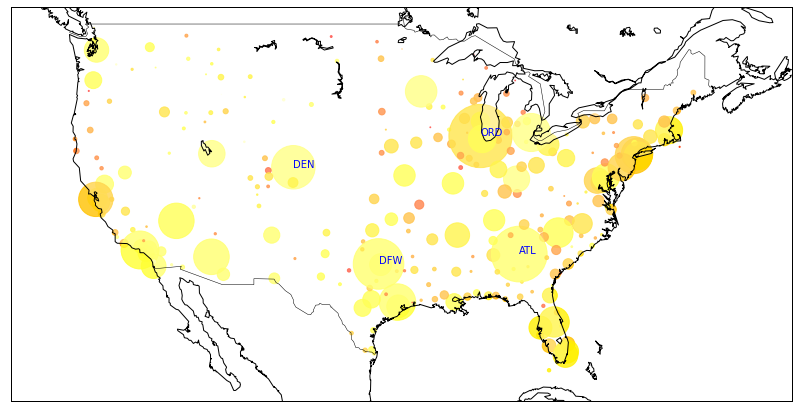

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

#----- Scatter -------
countrange=max(df_airports['conFlight'])-min(df_airports['conFlight'])
al=np.array([sigmoid(x) for x in zscore(df_airports['delay'])])
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
val=df_airports['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,color=colors[(al*20).astype(int)])

#----- Text -------
df_text=df_airports[(df_airports['conFlight']>20000) & (df_airports['faa_code'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['faa_code'])
zp=zip(xt,yt,txt)
for row in zp:
   
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue')

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()

# **Exploration: Route delay**
# Which Routes are typically the most delayed?

In [ ]:
grp_rout_Delay = sqlContext.sql("SELECT Origin, Dest, count(*) traffic,avg(Distance) avgDist,\
                                    avg(DepDelay) avgDelay\
                                FROM airlineDF \
                                GROUP BY Origin,Dest")
rout_Delay = grp_rout_Delay.toPandas()

In [ ]:
df_airport_rout1 = pd.merge(rout_Delay, airport_loc_df, left_on = 'Origin', right_on = 'faa_code')
df_airport_rout2 = pd.merge(df_airport_rout1, airport_loc_df, left_on = 'Dest', right_on = 'faa_code')
df_airport_rout = df_airport_rout2[["Origin","lat_x","lng_x","Dest","lat_y","lng_y",\
                                    "avgDelay", "traffic"]]

In [ ]:
df_airport_rout.sort_values('avgDelay',ascending=0).head()

,Origin,lat_x,lng_x,Dest,lat_y,lng_y,avgDelay,traffic
1121,SBN,41.708661,-86.317250,CVG,39.048836,-84.667822,518.000000,1
1857,MBS,43.532913,-84.079647,MSP,44.881956,-93.221767,368.000000,1
2178,EGE,39.642556,-106.917694,MIA,25.793250,-80.290556,289.555556,9
3983,HDN,40.481181,-107.217660,LGA,40.777245,-73.872608,258.000000,1
1673,BMI,40.477111,-88.915917,LAS,36.080056,-115.152250,239.000000,1


# Plot the map:
# Delayed routes are redder


Each line represents a route from the Origin to Destination airport.
The redder line, the higher probablity of delay.


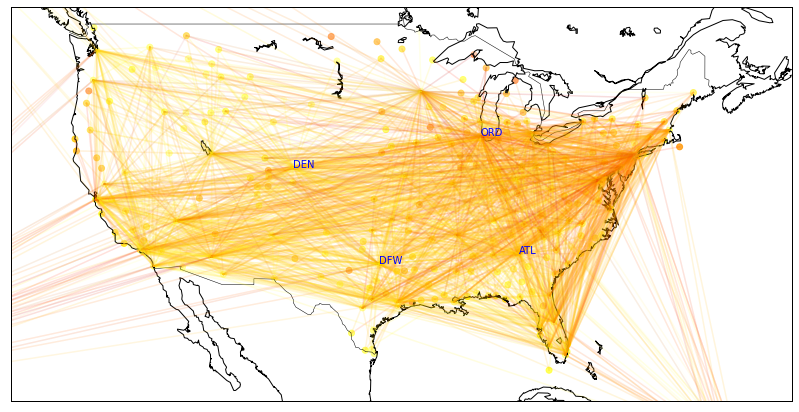

In [ ]:
rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

delay=np.array([sigmoid(x) for x in zscore(df_airports["delay"])])
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 40))
colors=np.flipud(colors)
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
xo,yo = my_map(np.asarray(df_airport_rout['lng_x']), np.asarray(df_airport_rout['lat_x']))
xd,yd = my_map(np.asarray(df_airport_rout['lng_y']), np.asarray(df_airport_rout['lat_y']))

my_map.scatter(xs, ys,  marker='o',  alpha = 0.8,color=colors[(delay*20).astype(int)])


al=np.array([sigmoid(x) for x in zscore(df_airport_rout["avgDelay"])])
f=zip(xo,yo,xd,yd,df_airport_rout['avgDelay'],al)
for row in f:
    plt.plot([row[0],row[2]], [row[1],row[3]],'-',alpha=0.07, \
             color=colors[(row[5]*30).astype(int)] )
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))    
txt=np.asarray(df_text['faa_code'])    
zp=zip(xt,yt,txt)
for row in zp:
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each line represents a route from the Origin to Destination airport.")
print("The redder line, the higher probablity of delay.")
    
plt.show()

# Exploration: Particular Airport Origin delay per month

In [ ]:
#considering San Jose California   
Origin_Airport="ORD"

In [ ]:
df_ORG = sqlContext.sql("SELECT * from airlineDF WHERE origin='"+ Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")
df_ORG.select('ArrTime','CRSArrTime','CRSDepTime',\
              'DayOfWeek','DayofMonth','DepDelay','DepTime','Dest').show(2)

+-------+----------+----------+---------+----------+--------+-------+----+
|ArrTime|CRSArrTime|CRSDepTime|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|
+-------+----------+----------+---------+----------+--------+-------+----+
| 2031.0|      1945|      1600|        2|         8|      71|   1711| EWR|
| 2040.0|      2004|      1742|        5|        25|      31|   1813| CLE|
+-------+----------+----------+---------+----------+--------+-------+----+
only showing top 2 rows



In [ ]:
print ("total flights from ORD airport: " + str(df_ORG.count()))

total flights from ORD airport: 53430


Each carrier delay from a particular airport in diff months

In [ ]:
grp_carr = sqlContext.sql("SELECT  UniqueCarrier,month, avg(DepDelay) avgDelay from df_ORG \
                            WHERE DepDelayed=True \
                            GROUP BY UniqueCarrier,month")
s = grp_carr.toPandas()

In [ ]:
ps = s.pivot(index='month', columns='UniqueCarrier', values='avgDelay')[['AA','UA','US']]

# June have max avg. delay for UA and AA carrier , April have higher avg delay for US carrier 




Text(0.5, 1.0, 'How much delay does each carrier has in each month?')

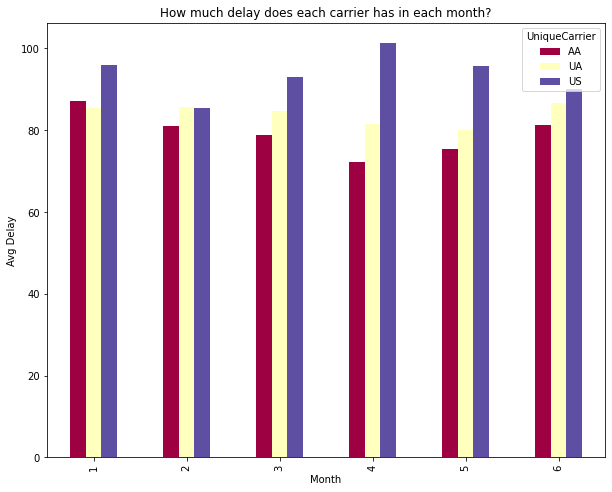

In [ ]:
rcParams['figure.figsize'] = (10,8)
ps.plot(kind='bar', colormap='Spectral');
plt.xlabel('Month')
plt.ylabel('Avg Delay')
plt.title('How much delay does each carrier has in each month?')

# Exploration: Airport Origin delay per day/hour

In [ ]:
hour_grouped = df_ORG.filter(df_ORG['DepDelayed']).select('DayOfWeek','hour','DepDelay').groupby('DayOfWeek','hour').mean('DepDelay')


Plot conclusion:

Mornings in first days of week possibly because of more business meetings

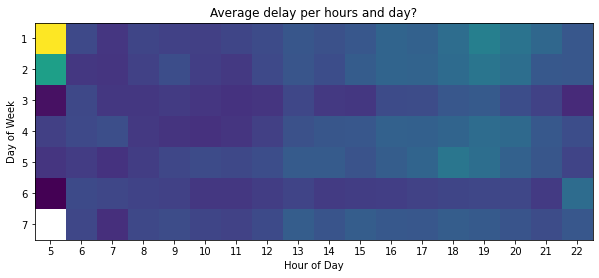

In [ ]:
rcParams['figure.figsize'] = (10,5)
dh = hour_grouped.toPandas()
c = dh.pivot('DayOfWeek','hour')
X = c.columns.levels[1].values
Y = c.index.values
Z = c.values
plt.xticks(range(0,24), X)
plt.yticks(range(0,7), Y)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average delay per hours and day?')
plt.imshow(Z)

# **MODEL**

In [ ]:
from pyspark.ml.feature import  OneHotEncoder
# Feature selection
df_model=df_ORG
stringIndexer1 = StringIndexer(inputCol="Origin", outputCol="originIndex")
model_stringIndexer = stringIndexer1.fit(df_model)
indexedOrigin = model_stringIndexer.transform(df_model)

encoder = OneHotEncoder(dropLast=False,inputCol="originIndex",outputCol="originVec")
encoder= encoder.fit(indexedOrigin)
df_model = encoder.transform(indexedOrigin)

In [ ]:
assembler = VectorAssembler(
    inputCols = ['Year','Month','DayofMonth','DayofWeek','hour','Distance','originVec'],
    outputCol = "features")
output = assembler.transform(df_model)
airlineRDD=output.rdd.map(lambda row: LabeledPoint([0,1][row['DepDelayed']],row['features'].toArray()))

In [ ]:
#  Spliting dataset into train and test dtasets
trainRDD,testRDD=airlineRDD.randomSplit([0.7,0.3])
print(output)

DataFrame[Year: int, Month: int, DayofMonth: int, DayofWeek: int, DepTime: int, CRSDepTime: int, ArrTime: float, CRSArrTime: int, UniqueCarrier: string, DepDelay: int, Origin: string, Dest: string, Distance: int, CarrierDelay: float, WeatherDelay: float, NASDelay: float, SecurityDelay: float, LateAircraftDelay: float, DepDelayed: boolean, hour: int, originIndex: double, originVec: vector, features: vector]


In [ ]:
from pyspark.ml.linalg import Vector as MLVector, Vectors as MLVectors
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors
from pyspark.mllib.regression import  LabeledPoint
# Build the model
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel, LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint

model = LogisticRegressionWithLBFGS.train(trainRDD)

In [ ]:
# Evaluating the model on testing data
labelsAndPreds = testRDD.map(lambda p: (p.label, model.predict(p.features)))

In [ ]:
def conf(r):
    if r[0] == r[1] ==1: x= 'TP'
    if r[0] == r[1] ==0: x= 'TN'
    if r[0] == 1 and  r[1] ==0: x= 'FN'
    if r[0] == 0 and  r[1] ==1: x= 'FP'
    return (x)
acc1 = labelsAndPreds.map(lambda vp: ((vp[0], vp[1]),1)).reduceByKey(lambda a, b: a + b).take(5)
acc = [(conf(x[0]),x[1]) for x in acc1]

In [ ]:
TP=TN=FP=FN=0.0
for x in acc: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
    
eps = sys.float_info.epsilon
Accuracy = (TP+TN) / (TP + TN+ FP+FN+eps) 
precision = TP/(TP+FP+eps)
recall = TP/(TP+FN+eps)
specificity=TN/(FN+TN+eps)
f1_score = 2*((precision*recall)/(precision+recall))
print ("Model Accuracy for ORD : %1.2f %%" % (Accuracy*100))
print ("Model Precision for ORD : %1.2f %%" % (precision*100))
print ("Model Recall for ORD : %1.2f %%" % (recall*100))
print ("Model Specificty for ORD: %1.2f %%" % (specificity*100))
print ("Model F1-score for ORD: %1.2f %%" % (f1_score*100))

Model Accuracy for ORD : 73.36 %
Model Precision for ORD : 73.38 %
Model Recall for ORD : 99.95 %
Model Specificty for ORD: 50.00 %
Model F1-score for ORD: 84.63 %
